# HW2.2 Ion Torrent read analysis

In [1]:
import pysam
import seaborn as sns
import numpy as np
import pandas as pd

from collections import Counter

In [15]:
reference_path = 'data/torrent/DH10B-K12.fasta'
read1_path = 'data/torrent/C24-698.fastq.gz'
read2_path = 'data/torrent/B22-730.fastq.gz'
alignment_c24_path = "./data/torrent/c24_alignment_sorted.bam"
alignment_b22_path = "./data/torrent/b22_alignment_sorted.bam"

In [3]:
!bwa index ./data/torrent/DH10B-K12.fasta

[bwa_index] Pack FASTA... 0.04 sec
[bwa_index] Construct BWT for the packed sequence...
[bwa_index] 1.23 seconds elapse.
[bwa_index] Update BWT... 0.03 sec
[bwa_index] Pack forward-only FASTA... 0.02 sec
[bwa_index] Construct SA from BWT and Occ... 0.39 sec
[main] Version: 0.7.17-r1188
[main] CMD: bwa index ./data/torrent/DH10B-K12.fasta
[main] Real time: 1.742 sec; CPU: 1.735 sec


In [7]:
!bwa mem "./data/torrent/DH10B-K12.fasta" "./data/torrent/C24-698.fastq" > "./data/torrent/c24_alignment.sam"

[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 40748 sequences (10000257 bp)...
[M::process] read 40830 sequences (10000256 bp)...
[M::mem_process_seqs] Processed 40748 reads in 3.254 CPU sec, 3.211 real sec
[M::process] read 40678 sequences (10000475 bp)...
[M::mem_process_seqs] Processed 40830 reads in 3.326 CPU sec, 3.235 real sec
[M::process] read 40934 sequences (10000123 bp)...
[M::mem_process_seqs] Processed 40678 reads in 4.016 CPU sec, 3.924 real sec
[M::process] read 40668 sequences (10000353 bp)...
[M::mem_process_seqs] Processed 40934 reads in 2.957 CPU sec, 2.861 real sec
[M::process] read 40714 sequences (10000220 bp)...
[M::mem_process_seqs] Processed 40668 reads in 2.902 CPU sec, 2.802 real sec
[M::process] read 40714 sequences (10000207 bp)...
[M::mem_process_seqs] Processed 40714 reads in 3.251 CPU sec, 3.157 real sec
[M::process] read 40584 sequences (10000468 bp)...
[M::mem_process_seqs] Processed 40714 reads in 2.985 CPU sec, 2.894 real sec
[M::pr

In [9]:
!bwa mem "./data/torrent/DH10B-K12.fasta" "./data/torrent/B22-730.fastq" > "./data/torrent/b22_alignment.sam"

[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 30580 sequences (10000589 bp)...
[M::process] read 30700 sequences (10000499 bp)...
[M::mem_process_seqs] Processed 30580 reads in 4.801 CPU sec, 4.767 real sec
[M::process] read 30654 sequences (10000464 bp)...
[M::mem_process_seqs] Processed 30700 reads in 5.228 CPU sec, 5.152 real sec
[M::process] read 30558 sequences (10000069 bp)...
[M::mem_process_seqs] Processed 30654 reads in 5.726 CPU sec, 5.638 real sec
[M::process] read 30468 sequences (10000148 bp)...
[M::mem_process_seqs] Processed 30558 reads in 4.315 CPU sec, 4.235 real sec
[M::process] read 30596 sequences (10000413 bp)...
[M::mem_process_seqs] Processed 30468 reads in 4.392 CPU sec, 4.304 real sec
[M::process] read 30514 sequences (10000381 bp)...
[M::mem_process_seqs] Processed 30596 reads in 4.704 CPU sec, 4.621 real sec
[M::process] read 30520 sequences (10000266 bp)...
[M::mem_process_seqs] Processed 30514 reads in 4.180 CPU sec, 4.099 real sec
[M::pr

In [136]:
!samtools view -S -b "./data/torrent/c24_alignment.sam" > "./data/torrent/c24_alignment.bam"

In [137]:
!samtools sort "./data/torrent/c24_alignment.bam"  -o "./data/torrent/c24_alignment_sorted.bam"

In [138]:
!samtools index "./data/torrent/c24_alignment_sorted.bam"

In [139]:
!samtools flagstat "./data/torrent/c24_alignment_sorted.bam"

686667 + 0 in total (QC-passed reads + QC-failed reads)
0 + 0 secondary
1261 + 0 supplementary
0 + 0 duplicates
682638 + 0 mapped (99.41% : N/A)
0 + 0 paired in sequencing
0 + 0 read1
0 + 0 read2
0 + 0 properly paired (N/A : N/A)
0 + 0 with itself and mate mapped
0 + 0 singletons (N/A : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


## Read analysis for B22-730.fastq.gz

In [94]:
b22_bam = pysam.AlignmentFile(alignment_b22_path, "rb")
contig = b22_bam.references[0]

In [96]:
ref_fasta = pysam.FastaFile(reference_path)
seq = ref_fasta.fetch(contig)

### 1.1 Genome coverage

In [143]:
def calculate_coverage(bamfile, contig, segment_lenght=5000):
    total_cov = []
    current_cov = 0
    prev_pos = 0
    skipped = 1
    
    for pile in bamfile.pileup(contig):
        current_pos = pile.pos
        if prev_pos + 1 != current_pos:
            skipped += current_pos - prev_pos - 1
        if current_pos // segment_lenght > prev_pos // segment_lenght:
            total_cov.append(current_cov / segment_lenght)
            current_cov = 0
        current_cov += pile.n
        prev_pos = current_pos
    coverage_frac = 1 - skipped / bamfile.lengths[0]
    return total_cov, coverage_frac * 100

Доля покрытия: 99.98798583993597 %. Среднее покрытие: 34.0339310565635


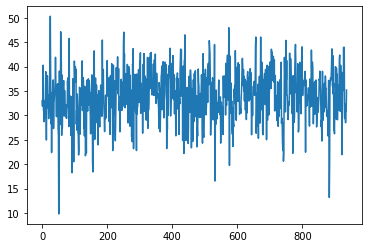

In [148]:
total_cov, coverage_percent = calculate_coverage(b22_bam, contig)
mean_coverage = np.array(total_cov).mean()
print(f'Доля покрытия: {coverage_percent} %. Среднее покрытие: {mean_coverage}')
sns.lineplot(x=range(len(total_cov)), y=total_cov)

### 1.2 Average error %

In [152]:
def get_avg_error(bamfile, contig, ref_seq):
    cumulative_error = 0
    total_read_len = 0
    
    ref_len = len(ref_seq)
    ref_gen = enumerate(ref_seq)
    pos, base = next(ref_gen)
    
    for read in bamfile.fetch(contig):
        total_read_len += read.query_alignment_length
        
    for pileupcolumn in bamfile.pileup(contig):
        while pos != pileupcolumn.reference_pos:
            pos, base = next(ref_gen)
            
        q_seq = pileupcolumn.get_query_sequences(add_indels=True)
        for seq in q_seq:
            if len(seq) == 1:
                ncl = seq.upper()
                if ncl != base:
                    cumulative_error += 1
            else:
                cumulative_error += 1
                
    return cumulative_error / total_read_len

In [154]:
avg_err = get_avg_error(b22_bam, contig, seq)
print('Average error %: ', avg_err * 100)

Average error %:  0.7099681840077506


### 1.3 Indel length stats

In [118]:
def calculate_indel_stats_from_cigar(bamfile, contig):
    indels_lengths = []
    for read in bamfile.fetch(contig):
        for operation, length in read.cigartuples:
            if operation == 1 or operation == 2:
                indels_lengths.append(length)
        
    return sum(indels_lengths) / len(indels_lengths)

In [119]:
print(f'Average indel length counted with cigar strings: {calculate_indel_stats_from_cigar(b22_bam, contig):.2f}')

Average indel length counted with cigar strings: 1.08


### 1.4 Indel length stats for homopolymer regions

In [263]:
def find_homopolymer_regions(seq):
    regions = []  # tuples (start, len)
    prev = None
    start_pos = 0
    current_len = 0
    
    for pos, base in enumerate(seq):
        if base == prev:
            current_len += 1
        else:
            if current_len > 2:
                regions.append((start_pos, current_len))
            current_len = 1
            start_pos = pos
            prev = base
    return regions
    

def calculate_indel_stats(bamfile, contig, ref_seq):
    homo_regions = dict(find_homopolymer_regions(ref_seq))
    indel_mtrx = pd.DataFrame({i: np.zeros(20) for i in range(1, 21)}, index=range(1, 21))
    i = 0
    for read in bamfile.fetch(contig):
        homo_pos = find_homopolymer_regions(read.query_sequence)
        pairs = dict(read.get_aligned_pairs())
        for read_pos, read_len in homo_pos:
            ref_pos = pairs[read_pos]
            if ref_pos is not None:
                ref_homo_region_len = homo_regions.get(ref_pos, None)
                if ref_homo_region_len is None:
                    s = ref_seq[ref_pos:ref_pos+20] + '0'  # add ending symbol
                    s_inv = ref_seq[ref_pos:max(ref_pos - 20, 0):-1] + '0'  # add ending symbol
                    ncl = s[0]
                    ref_homo_region_len = [c == ncl for c in s].index(False) + [c == ncl for c in s_inv].index(False) - 1 
                ref_homo_region_len = 20 if ref_homo_region_len > 20 else ref_homo_region_len
                read_len = 20 if read_len > 20 else read_len
                indel_mtrx.at[ref_homo_region_len, read_len] += 1
        
    return indel_mtrx

In [264]:
calculate_indel_stats(b22_bam, contig, seq)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
1,0.0,0.0,6419.0,2707.0,1169.0,586.0,246.0,78.0,53.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,11515.0,1027.0,390.0,136.0,67.0,24.0,28.0,6.0,2.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,11.0
3,0.0,0.0,5456557.0,5297.0,264.0,54.0,27.0,15.0,16.0,5.0,3.0,0.0,2.0,2.0,0.0,0.0,4.0,2.0,4.0,15.0
4,0.0,0.0,73605.0,1388033.0,2629.0,131.0,31.0,13.0,10.0,6.0,5.0,3.0,2.0,2.0,1.0,2.0,1.0,4.0,3.0,14.0
5,0.0,0.0,2450.0,44820.0,424426.0,1117.0,112.0,22.0,18.0,4.0,5.0,3.0,3.0,4.0,4.0,2.0,0.0,2.0,2.0,8.0
6,0.0,0.0,684.0,1368.0,24855.0,112922.0,395.0,109.0,45.0,18.0,6.0,2.0,4.0,3.0,4.0,0.0,2.0,1.0,3.0,5.0
7,0.0,0.0,201.0,259.0,805.0,11063.0,18108.0,125.0,79.0,33.0,11.0,12.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0
8,0.0,0.0,50.0,60.0,87.0,451.0,2187.0,2070.0,118.0,31.0,7.0,4.0,4.0,2.0,0.0,0.0,1.0,0.0,1.0,2.0
9,0.0,0.0,10.0,6.0,7.0,29.0,69.0,62.0,224.0,11.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,9.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 1.5 Base quality stats

In [134]:
def get_base_quality_stats(bamfile, contig, ref_seq):
    insertion_cumulative_qual = 0
    insertion_number = 0
    
    subst_cumulative_qual = 0
    subst_number = 0
    
    ref_gen = enumerate(ref_seq)
    pos, base = next(ref_gen)
    
    for pileupcolumn in bamfile.pileup(contig):
        while pos != pileupcolumn.reference_pos:
            pos, base = next(ref_gen)
        query_seq = pileupcolumn.get_query_sequences(add_indels=True)
        qual_seq = pileupcolumn.get_mapping_qualities()
        for seq, qual in zip(query_seq, qual_seq):
            if seq.upper() != base:
                if len(seq) == 1:
                    subst_cumulative_qual += qual
                    subst_number += 1
                elif seq[1] == '+':
                    insertion_cumulative_qual += qual
                    insertion_number += 1
                
    return insertion_cumulative_qual / insertion_number, subst_cumulative_qual / subst_number

In [135]:
insertion_avg_qual, subst_avg_qual = get_base_quality_stats(b22_bam, contig, seq)
print(f'Среднее качаство нуклеотида при ошибочной вставке: {insertion_avg_qual:.2f}')
print(f'Среднее качаство нуклеотида при замене: {subst_avg_qual:.2f}')

Среднее качаство нуклеотида при ошибочной вставке: 55.88
Среднее качаство нуклеотида при замене: 56.05


### 1.6 Substitution matrix

In [226]:
def build_substitution_matrix(bamfile, contig, ref_seq):
    substitution_matrix = pd.DataFrame(
        {'A': [0,0,0,0,0], 'C': [0,0,0,0,0], 'G': [0,0,0,0,0], 'T': [0,0,0,0,0], '-': [0,0,0,0,0]}, 
        index=['A', 'C', 'G', 'T', '-']
    )
    
    ref_gen = enumerate(ref_seq)
    pos, base = next(ref_gen)

    for pileupcolumn in bamfile.pileup(contig):
        while pos != pileupcolumn.reference_pos:
            pos, base = next(ref_gen)
            
        q_seq = pileupcolumn.get_query_sequences(add_indels=True)
        for seq in q_seq:
            if len(seq) == 1:
                ncl = seq.upper()
                if ncl != base and ncl != 'N':
                    if ncl == '*':
                        substitution_matrix.at[base, '-'] += 1
                    else:
                        substitution_matrix.at[base, ncl] += 1
            elif seq[1] == '+':
                ncl_list = list(filter(lambda x: x.isalpha(), seq[2:]))
                for ncl in ncl_list:
                    substitution_matrix.at['-', ncl.upper()] += 1
                
    return substitution_matrix

In [83]:
mtrx = build_substitution_matrix(b22_bam, contig, seq)
print(mtrx)

        A      C      G       T      -
A       0   6206  20235    7446  88856
C    6798      0   5290   13109  57546
G   13630   4715      0    6992  57428
T    7566  20799   6149       0  89543
-  155837  63989  64873  159752      0


## Read analysis for C24-698.fastq.gz

In [216]:
c24_bam = pysam.AlignmentFile(alignment_c24_path, "rb")
c24_contig = c24_bam.references[0]

Доля покрытия: 100.0 %. Среднее покрытие: 35.704731696905014


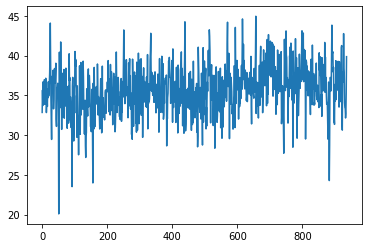

In [217]:
total_cov, coverage_percent = calculate_coverage(c24_bam, c24_contig)
mean_coverage = np.array(total_cov).mean()
print(f'Доля покрытия: {coverage_percent} %. Среднее покрытие: {mean_coverage}')
sns.lineplot(x=range(len(total_cov)), y=total_cov)

In [218]:
avg_err = get_avg_error(c24_bam, c24_contig, seq)
print('Average error %: ', avg_err * 100)

Average error %:  0.4117687755704975


In [219]:
indel_length = calculate_indel_stats_from_cigar(c24_bam, c24_contig)
print(f'Average indel length counted with cigar strings: {indel_length:.2f}')

Average indel length counted with cigar strings: 1.07


In [259]:
print('Indel length in reference(rows) vs in read(columns).')
indel_mtrx = calculate_indel_stats(c24_bam, c24_contig, seq)
indel_mtrx

Indel length in reference(rows) vs in read(columns).


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
1,0.0,0.0,4295.0,1058.0,347.0,162.0,64.0,28.0,15.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,6668.0,671.0,174.0,52.0,18.0,13.0,4.0,2.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,3.0
3,0.0,0.0,5739746.0,1835.0,98.0,24.0,11.0,7.0,3.0,2.0,3.0,1.0,1.0,2.0,1.0,0.0,1.0,1.0,2.0,7.0
4,0.0,0.0,35628.0,1500356.0,606.0,37.0,7.0,3.0,0.0,1.0,0.0,1.0,4.0,0.0,1.0,0.0,0.0,1.0,0.0,4.0
5,0.0,0.0,2523.0,16616.0,478180.0,340.0,20.0,3.0,1.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,3.0
6,0.0,0.0,776.0,906.0,8775.0,139334.0,144.0,29.0,7.0,4.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0
7,0.0,0.0,163.0,171.0,307.0,4100.0,29435.0,82.0,19.0,9.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0
8,0.0,0.0,42.0,33.0,51.0,99.0,906.0,6115.0,27.0,10.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,4.0,2.0,6.0,3.0,8.0,110.0,462.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,8.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [220]:
insertion_avg_qual, subst_avg_qual = get_base_quality_stats(c24_bam, c24_contig, seq)
print(f'Среднее качаство нуклеотида при ошибочной вставке: {insertion_avg_qual:.2f}')
print(f'Среднее качаство нуклеотида при замене: {subst_avg_qual:.2f}')

Среднее качаство нуклеотида при ошибочной вставке: 55.33
Среднее качаство нуклеотида при замене: 55.51


In [227]:
mtrx = build_substitution_matrix(c24_bam, c24_contig, seq)
print(mtrx)

       A      C      G      T      -
A      0   3358  19448   4497  26798
C   4628      0   3470  11745  74177
G  11986   3229      0   4929  70174
T   4558  19704   3420      0  27900
-  65002  36050  35567  65963      0


## Bowtie2

In [ ]:
!bowtie2 -x ref.index -U C24-698.fastq | samtools view -bS - | samtools sort -o  ./data/torrent/c24_bt2_alignment.bam

Bowtie2 allignment stats for C24:
685406 reads; of these:
  685406 (100.00%) were unpaired; of these:
    5140 (0.75%) aligned 0 times
    629223 (91.80%) aligned exactly 1 time
    51043 (7.45%) aligned >1 times
99.25% overall alignment rate

In [237]:
c24_bt_alignment = "./data/torrent/c24_bt2_alignment.bam"
c24_bt_bam = pysam.AlignmentFile(c24_bt_alignment, "rb")
c24_bt_contig = c24_bt_bam.references[0]

Доля покрытия: 100.0 %. Среднее покрытие: 35.699416648879414


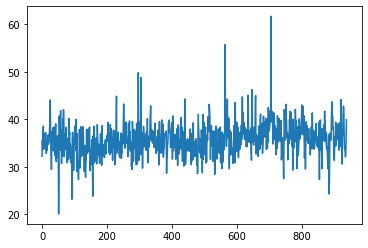

In [238]:
total_cov, coverage_percent = calculate_coverage(c24_bt_bam, c24_bt_contig)
mean_coverage = np.array(total_cov).mean()
print(f'Доля покрытия: {coverage_percent} %. Среднее покрытие: {mean_coverage}')
sns.lineplot(x=range(len(total_cov)), y=total_cov)

In [239]:
avg_err = get_avg_error(c24_bt_bam, c24_bt_contig, seq)
print('Average error %: ', avg_err * 100)

Average error %:  0.46488064520518685


In [240]:
indel_length = calculate_indel_stats_from_cigar(c24_bt_bam, c24_bt_contig)
print(f'Average indel length counted with cigar strings: {indel_length:.2f}')

Average indel length counted with cigar strings: 1.08


In [265]:
print('Indel length in reference(rows) vs in read(columns).')
indel_mtrx_bt = calculate_indel_stats(c24_bt_bam, c24_bt_contig, seq)
indel_mtrx_bt

Indel length in reference(rows) vs in read(columns).


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
1,0.0,0.0,6577.0,1738.0,545.0,282.0,135.0,79.0,31.0,10.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,3.0,4.0
2,0.0,0.0,7876.0,873.0,230.0,81.0,36.0,31.0,10.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
3,0.0,0.0,5730293.0,2017.0,112.0,31.0,16.0,12.0,4.0,1.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
4,0.0,0.0,36822.0,1497616.0,626.0,42.0,10.0,5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0
5,0.0,0.0,2709.0,16892.0,477194.0,360.0,22.0,5.0,1.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
6,0.0,0.0,849.0,969.0,8788.0,139010.0,149.0,21.0,6.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,178.0,183.0,321.0,4082.0,29343.0,75.0,13.0,5.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8,0.0,0.0,46.0,34.0,54.0,106.0,903.0,6106.0,28.0,8.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,5.0,2.0,6.0,3.0,7.0,110.0,462.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,2.0,2.0,2.0,1.0,8.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [241]:
insertion_avg_qual, subst_avg_qual = get_base_quality_stats(c24_bt_bam, c24_bt_contig, seq)
print(f'Среднее качаство нуклеотида при ошибочной вставке: {insertion_avg_qual:.2f}')
print(f'Среднее качаство нуклеотида при замене: {subst_avg_qual:.2f}')

Среднее качаство нуклеотида при ошибочной вставке: 31.73
Среднее качаство нуклеотида при замене: 35.43


In [242]:
mtrx = build_substitution_matrix(c24_bt_bam, c24_bt_contig, seq)
print(mtrx)

       A      C      G      T      -
A      0   9749  25763  11513  26464
C  12292      0  10603  18446  74017
G  18888  10222      0  12527  70416
T  11656  26001   9724      0  27593
-  68792  39850  38846  69922      0
